# Linear Factor Models

## Loading Packages

In [1]:
using Compat, Missings        #in Julia 0.6 
#using Dates, DelimitedFiles  #in Julia 0.7

include("jlFiles/printmat.jl")
include("jlFiles/NWFn.jl")
include("jlFiles/OlsSureFn.jl")

OlsSureFn

In [2]:
using Plots

backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

In [3]:
"""
    Inn(n)

Create identity matrix (n rows, n columns)
"""
Inn(n) = Matrix(1.0I,n,n)           

Inn

## Loading Data

In [4]:
xx   = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = xx[:,2]
RSMB = xx[:,3]                #small minus big firms
RHML = xx[:,4]                #high minus low book-to-market ratio
Rf   = xx[:,5]                #interest rate


xx = readdlm("Data/FF25Ps.csv",',')  #no header line: x is matrix
R  = xx[:,2:end]                      #returns for 25 FF portfolios
Re = R .- Rf                         #excess returns for the 25 FF portfolios
xx = nothing

(T,n) = size(Re)                 #no. obs and  no. test assets

(388, 25)

# Testing alpha from Time Series Regressions


With $n$ test assets and $K$ excess return factors, the linear factor model is

$
R_{t}^{e}=\alpha+\beta f_{t}+\varepsilon_{t},
$

and the testable hypothesis is that all alphas are zero. 

The moment conditions
are

$
\text{E}g_{t}(\alpha,\beta)=\text{E}\left(  \left[
\begin{array}
[c]{c}
1\\
f_{t}
\end{array}
\right]  \otimes\varepsilon_{t}\right)  =\text{E}\left(  \left[
\begin{array}
[c]{c}
1\\
f_{t}
\end{array}
\right]  \otimes(R_{t}^{e}-\alpha-\beta f_{t})\right)  =\mathbf{0}
_{n(1+K)\times1}.
$


Since the model is exactly identified, the GMM covariance matrix of the
parameters ($\alpha,\beta$) is

$
\sqrt{T}(\hat{\beta}-\beta_{0})\overset{d}{\rightarrow}N(0,V) 
\: \text{ where } \: 
V=D_{0}^{-1}S(D_{0}^{-1})^{\prime},
$

where $S$ is the covariance matrix of $\sqrt{T}\bar{g}_{t}$  and $D_{0}$ is
the Jacobian which here equals

$
D_{0}=-\operatorname*{E}\left(  \left[
\begin{array}[c]{c}
1\\
f_{t}
\end{array}
\right]  \left[
\begin{array}
[c]{c}
1\\
f_{t}
\end{array}
\right]  ^{\prime}\right)  \otimes I_{n} \ \text{ so }  
$

$
\ D_{0}^{-1}=-\left[\text{E}\left(  \left[
\begin{array}[c]{c}
1\\
f_{t}
\end{array}
\right]  \left[
\begin{array}[c]{c}
1\\
f_{t}
\end{array}
\right]  ^{\prime}\right)  \right]  ^{-1} \otimes I_{n}
$

In [5]:
                                          #FF, testing alphas
F         = [ones(T) Rme RSMB RHML]       #factors, constant and 3 FF factors

(b,epsM,) = OlsSureFn(Re,F)                  #point estimates and residuals                   
alfaM     = b[1,:]                        #n vector

g = fill(NaN,(T,size(F,2)*n))             #moment conditions, regressors*residual
for t = 1:T
  g[t,:] = kron(F[t:t,:],epsM[t:t,:])
end
S0   = NWFn(g,0)                          #ACov(sqrt(T)*gbar)
Sxx  = F'F/T                                
D0_1 = -kron(inv(Sxx),Inn(n))             #inverse of Jacobian
V    = D0_1*S0*D0_1'                      #covariance matrix(all coeffs)

WaldStat  = alfaM'inv(V[1:n,1:n]/T)*alfaM   #test if all alpha=0

println("\nTesting alpha = 0, test statistic, df, and 10% critical value of Chi-square(25)")
printmat([WaldStat length(alfaM) 34.38])


Testing alpha = 0, test statistic, df, and 10% critical value of Chi-square(25)
   162.011    25.000    34.380



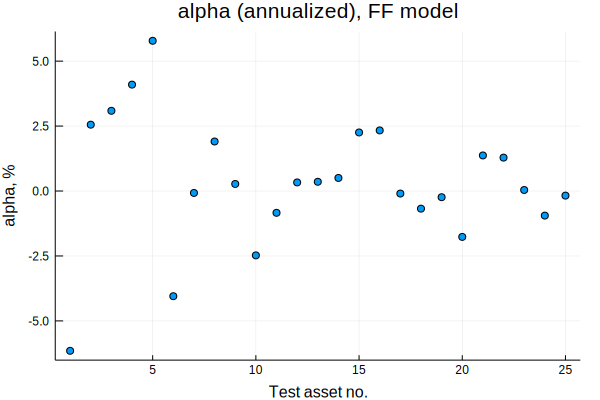

In [6]:
scatter(alfaM*12,legend=false)
title!("alpha (annualized), FF model")
xlabel!("Test asset no.")
ylabel!("alpha, %")

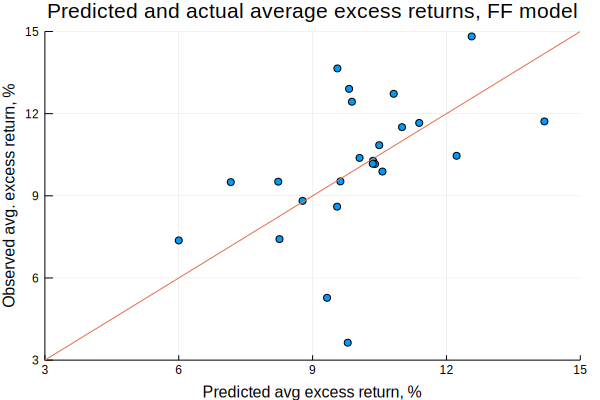

In [7]:
ERe   = Compat.mean(Re,dims=1)          #average excess returns, 0.7 syntax
ReHat = Compat.mean(F[:,2:end],dims=1)*b[2:end,:]   #predicted average returns, setting alpha=0 

scatter(ReHat'*12,ERe'*12,legend=false)
plot!([0;20],[0,20])
plot!(xlims=(3,15),ylims=(3,15))
title!("Predicted and actual average excess returns, FF model")
xlabel!("Predicted avg excess return, %")
ylabel!("Observed avg. excess return, %")

# Cross-Sectional Regressions

The following code from uses GMM to test $\operatorname*{E}R^{e}=\beta^{\prime}\lambda$ from an FF model---the case of
"General Factors".

(The factors happen to be excess returns,
but that does not stop us from applying the method for general factors.) 

The code applies GMM without a weighting function. Instead, an $A$ matrix is defined
such that $A\bar{g}=\mathbf{0}$ becomes the effective moment conditions. The
matrix is chosen to make the factor risk premia ($\lambda$) the same as in the
old-fashioned cross-sectional regressions.

## Getting the Point Estimates

In [8]:
                                          #FF, testing ERe = lambda'beta
F         = [ones(T) Rme RSMB RHML]       #factors, constant and 3 FF factors
K         = size(F,2) - 1                 #number of factors, excluding constant
(b,epsM,) = OlsSureFn(Re,F)
bM        = copy(b')                      #nx(1+K)

ERe    = Compat.mean(Re,dims=1)'          #0.7 syntax
betaM  = bM[:,2:end]
theta  = betaM'
lambda = (theta*betaM)\(theta*ERe)       #cross-sectional estimate of price of factor risk

println("lambda:")
printmat(lambda)

lambda:
     0.567
     0.252
     0.439



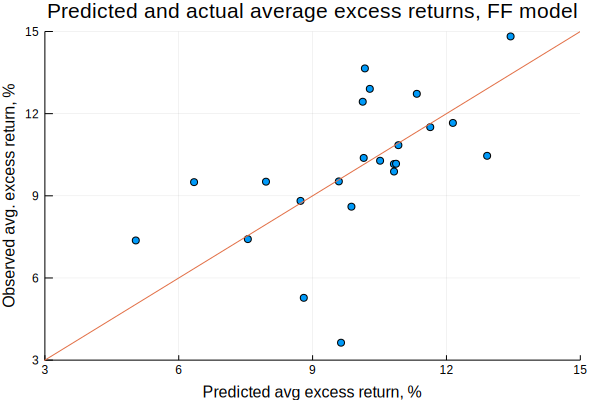

In [9]:
ReHatC = lambda'*b[2:end,:]   #predicted average returns, setting alpha=0 

scatter(ReHatC'*12,vec(ERe)*12,legend=false)
plot!([0;20],[0,20])
plot!(xlims=(3,15),ylims=(3,15))
title!("Predicted and actual average excess returns, FF model")
xlabel!("Predicted avg excess return, %")
ylabel!("Observed avg. excess return, %")

## Comparing the Cross-Sectional and Time-Series Results

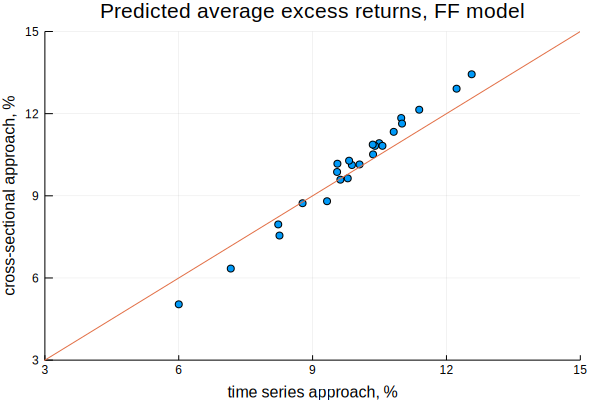

In [10]:
scatter(ReHat'*12,ReHatC'*12,legend=false)
plot!([0;20],[0,20])
plot!(xlim=(3,15),ylim=(3,15))
title!("Predicted average excess returns, FF model")
xlabel!("time series approach, %")
ylabel!("cross-sectional approach, %")

## Testing the Cross-Sectional Results

In [11]:

g = fill(NaN,(T,size(F,2)*n))           #moment conditions, regressors*residual
for t = 1:T
  g[t,:] = kron(F[t:t,:],epsM[t:t,:])
end
g = [g (Re .- lambda'*betaM')]

p = length(bM) + length(lambda)             #no. parameters
q = size(g,2)                               #no. moment conditions

gbar = vec(Compat.mean(g,dims=1))          #0.7 syntax
println("the sample moment conditions are (reshaped as n x (1+K+1)):")
printmat(reshape(gbar,n,K+2))

S0   = NWFn(g,0)
Sxx  = F'F/T
D0LL = kron([0 lambda'],Inn(n))             #lower left of D0
D0   = - [kron(Sxx,Inn(n)) zeros(n*(1+K),K);
          D0LL             betaM           ]

A    = [Inn(n*(1+K))     zeros(n*(1+K),n);     #A*gbar, traditional approach
        zeros(K,n*(1+K)) theta ]
#A    = [I     zeros(n*(1+K),n);     in 0.7
#        zeros(K,n*(1+K)) theta ]

Psia = Inn(q) - D0*inv(A*D0)*A
#Psia = I - D0*inv(A*D0)*A               in 0.7
Psi3 = Psia*S0*Psia'                          #Cov[sqrt(T)*gbar], rank q-p

WaldStat  = gbar'pinv(Psi3/T)*gbar            #test of moment conditions

println("\nTesting ERe = lambda'beta:")
println("test statistic    df       10% critical value of Chi-square(22)")
printmat([WaldStat (q-p) 30.81],12,3)

the sample moment conditions are (reshaped as n x (1+K+1)):
     0.000    -0.000     0.000    -0.000    -0.500
    -0.000     0.000    -0.000     0.000     0.193
    -0.000    -0.000     0.000     0.000     0.219
    -0.000    -0.000    -0.000     0.000     0.290
     0.000     0.000     0.000     0.000     0.411
     0.000     0.000     0.000    -0.000    -0.294
     0.000     0.000     0.000    -0.000    -0.019
    -0.000     0.000    -0.000    -0.000     0.116
     0.000     0.000    -0.000     0.000    -0.040
    -0.000     0.000    -0.000    -0.000    -0.302
     0.000    -0.000    -0.000     0.000    -0.011
     0.000     0.000     0.000    -0.000     0.020
    -0.000    -0.000    -0.000     0.000    -0.006
    -0.000    -0.000    -0.000     0.000    -0.011
    -0.000    -0.000     0.000     0.000     0.115
    -0.000    -0.000     0.000     0.000     0.263
    -0.000    -0.000    -0.000     0.000    -0.005
     0.000     0.000     0.000    -0.000    -0.078
    -0.000    -0.000  